## Plotly plot of chord diagrams ##

Circular layout or [Chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) is a method of visualizing  data that describe relationships. It was intensively promoted  through [Circos](http://circos.ca/), a software package in Perl that  was initially designed for displaying genomic data.

In [2]:
from IPython.display import Image
Image(url='http://mkweb.bcgsc.ca/tableviewer/tmp/uzofjjnsamp/results/circos-table-uzofjjnsamp.png')

M Bostock developed reusable charts  for [chord diagrams](http://bl.ocks.org/mbostock/4062006) in d3.js

Two years ago on [stackoverflow](http://stackoverflow.com/questions/19105801/chord-diagram-in-python) it was adressed the question whether there is a Python package for plotting  chord diagrams. The question was  closed as being considered *off topic*.

In this Jupyter Notebook we show that a chord diagram can be generated with Python Plotly.

We illustrate the method of generating a chord diagram from data recorded in a square matrix.  The rows and columns represent  the same entities.

 Suppose that for a community of 5 friends on Facebook we record  the number of comments posted by each member on other friends wall. The data table is given in the next cell: 

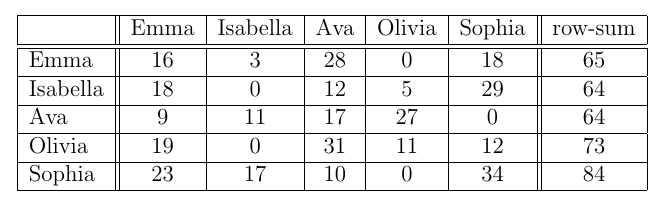

In [3]:
Image(filename='Data/Data-table.png')

The aim of our visualization is to illustrate the total number of posts by each community member, and the 
flows of posts between pairs of friends.

In [4]:
import numpy as np

Define the array of data:

In [5]:
matrix=np.array([[16,  3, 28,  0, 18],
                 [18,  0, 12,  5, 29],
                 [ 9, 11, 17, 27,  0],  
                 [19,  0, 31, 11, 12],
                 [23, 17, 10,  0, 34]], dtype=int)

In [6]:
def check_data(data_matrix):
    L, M=data_matrix.shape
    if L!=M:
        raise ValueError('Data array must have (n,n) shape')
    return L

In [7]:
L=check_data(matrix)

A chord diagram encodes information in two graphical objects:
  - ideograms, represented by   distinctly colored arcs of circles;
  - ribbons, that are planar shapes bounded by two quadratic Bezier curves and two arcs of circle,that can degenerate to a point;

### Ideograms ###

Summing up the entries on each matrix row, one gets a value (in our example this value is equal to the number of posts by a community member).
Let us denote by `total_comments` the total number of posts recorded in this community.

Theoretically the interval `[0, total_comments)` is mapped linearly onto the unit circle, identified with the interval $[0,2\pi)$. 

For a better looking plot one proceeds as follows: starting from the angular position $0$, in counter-clockwise direction, one draws succesively, around the unit circle,  two parallel arcs of length equal to a mapped row sum value, minus a fixed gap. Click the image below:



<div>
    <a href="https://plot.ly/~empet/12234/" target="_blank" title="Ideograms" style="display: block; text-align: center;"><img src="https://plot.ly/~empet/12234.png" alt="Ideograms" style="max-width: 100%;width: 400px;"  width="400" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="empet:12234"  src="https://plot.ly/embed.js" async></script>
</div>


Now we define the functions that process  data in order to get ideogram ends.

As we stressed the unit circle is oriented counter-clockwise.
In order to get  an arc of circle of  end angular
coordinates $\theta_0<\theta_1$, we define a function `moduloAB` that resolves the case when an arc contains
the  point of angular coordinate $0$ (for example $\theta_0=2\pi-\pi/12$, $\theta_1=\pi/9$). The function corresponding to $a=-\pi, b=\pi$  allows to map the interval $[0,2\pi)$ onto $[-\pi, \pi)$. Via this transformation we have:

$\theta_0\mapsto \theta'_0=-\pi/12$, and 

$ \theta_1=\mapsto \theta'_1=\pi/9$,

and now $\theta'_0<\theta'_1$.

In [8]:
PI=np.pi

In [9]:
def moduloAB(x, a, b): #maps a real number onto the unit circle identified with 
                       #the interval [a,b), b-a=2*PI
        if a>=b:
            raise ValueError('Incorrect interval ends')
        y=(x-a)%(b-a)
        return y+b if y<0 else y+a

In [10]:
def test_2PI(x):
     return 0<= x <2*PI

Compute the row sums and the lengths of corresponding ideograms:

In [11]:
row_sum=[np.sum(matrix[k,:]) for k in range(L)]

#set the gap between two consecutive ideograms
gap=2*PI*0.005
ideogram_length=2*PI*np.asarray(row_sum)/sum(row_sum)-gap*np.ones(L)

The next function returns the list of  end angular coordinates for each ideogram arc:

In [12]:
def get_ideogram_ends(ideogram_len, gap):
    ideo_ends=[]
    left=0
    for k in range(len(ideogram_len)):
        right=left+ideogram_len[k]
        ideo_ends.append([left, right])   
        left=right+gap
    return ideo_ends 

In [13]:
ideo_ends=get_ideogram_ends(ideogram_length, gap)
ideo_ends

[[0, 1.1354613447974538],
 [1.1668772713333517, 2.2843866581102921],
 [2.3158025846461898, 3.4333119714231302],
 [3.4647278979590279, 4.7438049069205865],
 [4.7752208334564843, 6.2517693806436867]]

The function `make_ideogram_arc` returns equally spaced points on an ideogram arc, expressed as complex
numbers in polar form:

In [14]:
def make_ideogram_arc(R, phi, a=50):
    # R is the circle radius
    # phi is the list of ends angle coordinates of an arc
    # a is a parameter that controls the number of points to be evaluated on an arc
    if not test_2PI(phi[0]) or not test_2PI(phi[1]):
        phi=[moduloAB(t, 0, 2*PI) for t in phi]
    length=(phi[1]-phi[0])% 2*PI 
    nr=5 if length<=PI/4 else int(a*length/PI)

    if phi[0] < phi[1]:   
        theta=np.linspace(phi[0], phi[1], nr)
    else:
        phi=[moduloAB(t, -PI, PI) for t in phi]
        theta=np.linspace(phi[0], phi[1], nr)
    return R*np.exp(1j*theta)   

The real and imaginary parts of these complex numbers will be used to define the ideogram as a [Plotly
shape](https://plot.ly/python/shapes/) bounded by a SVG path.

In [15]:
z=make_ideogram_arc(1.3, [11*PI/6, PI/17])
print z

[ 1.12583302-0.65j        1.14814501-0.60972373j  1.16901672-0.5686826j
  1.18842197-0.5269281j   1.20633642-0.48451259j  1.22273759-0.44148929j
  1.23760491-0.39791217j  1.25091973-0.3538359j   1.26266534-0.30931575j
  1.27282702-0.26440759j  1.28139202-0.21916775j  1.28834958-0.17365297j
  1.29369099-0.12792036j  1.29740954-0.08202728j  1.29950058-0.0360313j
  1.29996146+0.01000988j  1.29879163+0.0560385j   1.29599253+0.10199682j
  1.29156770+0.1478272j   1.28552267+0.19347214j  1.27786503+0.23887437j]


Set ideograms labels and colors:

In [17]:
labels=['Emma', 'Isabella', 'Ava', 'Olivia', 'Sophia']
ideo_colors=['rgba(244, 109, 67, 0.75)',
             'rgba(253, 174, 97, 0.75)',
             'rgba(254, 224, 139, 0.75)',
             'rgba(217, 239, 139, 0.75)',
             'rgba(166, 217, 106, 0.75)']#brewer colors with alpha set on 0.75

### Ribbons in a chord diagram ###

While ideograms illustrate how many comments posted each member of the Facebook community,  ribbons
give a comparative information on the flows of comments from one friend to another.

To illustrate this flow we map data onto the unit circle. More precisely, for each matrix row, $k$, the application:

`t`$\mapsto$ `t*ideogram_length[k]/row_sum[k]`

maps the interval `[0, row_sum[k]]` onto
the interval `[0, ideogram_length[k]]`. Hence each entry `matrix[k][j]` of the $k^{th}$  row is mapped to `matrix[k][j]*ideogram_length[k]/row_value[k]`.

The function `map_data` maps all matrix entries to the corresponding values in the intervals associated to ideograms:

In [18]:
def map_data(data_matrix, row_value, ideogram_length):
    mapped=np.zeros(data_matrix.shape)
    for j  in range(L):
        mapped[:, j]=ideogram_length*data_matrix[:,j]/row_value
    return mapped  

In [19]:
mapped_data=map_data(matrix, row_sum, ideogram_length)
mapped_data

array([[ 0.27949818,  0.05240591,  0.48912181,  0.        ,  0.31443545],
       [ 0.31429952,  0.        ,  0.20953301,  0.08730542,  0.50637144],
       [ 0.15714976,  0.19207193,  0.29683843,  0.47144927,  0.        ],
       [ 0.33291045,  0.        ,  0.54316969,  0.19273763,  0.21025923],
       [ 0.40429305,  0.2988253 ,  0.17577959,  0.        ,  0.5976506 ]])

- To each pair of values `(mapped_data[k][j], mapped_data[j][k])`, $k<=j$,  one associates a ribbon, that is a curvilinear filled rectangle (that can be degenerate), having as opposite sides two subarcs of the $k^{th}$ ideogram, respectively $j^{th}$ ideogram, and two arcs of quadratic B&eacute;zier curves.

Here we illustrate the ribbons associated to pairs `(mapped_data[0][j], mapped_data[j][0])`, $j=\overline{0,4}$,
that illustrate the flow of comments between Emma and all other friends, and  herself:

<div>
    <a href="https://plot.ly/~empet/12519/" target="_blank" title="Ribbons" style="display: block; text-align: center;"><img src="https://plot.ly/~empet/12519.png" alt="Ribbons" style="max-width: 100%;width: 400px;"  width="400" onerror="this.onerror=null;this.src='https://plot.ly/404.png';" /></a>
    <script data-plotly="empet:12519"  src="https://plot.ly/embed.js" async></script>
</div>



- For a better looking chord diagram, 
[Circos documentation](http://circos.ca/presentations/articles/vis_tables1/) recommends to sort increasingly each row of the mapped_data. 

The  array `idx_sort`, defined below, has on each row the indices that sort the corresponding row in `mapped_data`:

In [22]:
idx_sort=np.argsort(mapped_data, axis=1)
idx_sort

array([[3, 1, 0, 4, 2],
       [1, 3, 2, 0, 4],
       [4, 0, 1, 2, 3],
       [1, 3, 4, 0, 2],
       [3, 2, 1, 0, 4]])

In the following we call ribbon ends, the lists `l=[l[0], l[1]]`, `r=[r[0], r[1]]` having as elements the angular coordinates
of the ends of arcs that are opposite sides in a ribbon. These arcs are sub-arcs in the internal boundaries of
the ideograms, connected by the ribbon
(see the image above).

- Compute the ribbon ends  and store them as tuples 
in a list of lists ($L\times L$):

In [23]:
def make_ribbon_ends(mapped_data, ideo_ends,  idx_sort):
    L=mapped_data.shape[0]
    ribbon_boundary=np.zeros((L,L+1))
    for k in range(L):
        start=ideo_ends[k][0]
        ribbon_boundary[k][0]=start
        for j in range(1,L+1):
            J=idx_sort[k][j-1]
            ribbon_boundary[k][j]=start+mapped_data[k][J]
            start=ribbon_boundary[k][j]
    return [[(ribbon_boundary[k][j],ribbon_boundary[k][j+1] ) for j in range(L)] for k in range(L)]   

In [24]:
ribbon_ends=make_ribbon_ends(mapped_data, ideo_ends,  idx_sort)
print 'ribbon ends starting from the ideogram[2]\n', ribbon_ends[2]

ribbon ends starting from the ideogram[2]
[(2.3158025846461898, 2.3158025846461898), (2.3158025846461898, 2.472952342161697), (2.472952342161697, 2.6650242680139837), (2.6650242680139837, 2.9618626988766086), (2.9618626988766086, 3.4333119714231302)]


We note that `ribbon_ends[k][j]` correspond to `mapped_data[i][idx_sort[k][j]]`, i.e. the length of the arc of ends
in `ribbon_ends[k][j]` is equal to `mapped_data[i][idx_sort[k][j]]`.

Now we define a few functions that compute the  control points for B&eacute;zier ribbon sides.

The function `control_pts` returns the cartesian coordinates of  the  control points, $b_0, b_1, b_2$, supposed as being  initially located on the unit circle, and thus defined only by their angular coordinate.  The angular coordinate
of the point $b_1$ is the mean of angular coordinates of the points $b_0, b_2$.

Since for a  B&eacute;zier ribbon side only $b_0, b_2$ are placed on the unit circle, one gives `radius` as a parameter that controls position of $b_1$.  `radius` is the distance  of $b_1$ to the circle center.

In [41]:
def control_pts(angle, radius):
    #angle is a  3-list containing angular coordinates of the control points b0, b1, b2
    #radius is the distance from b1 to the  origin O(0,0) 

    if len(angle)!=3:
        raise InvalidInputError('angle must have len =3')
    b_cplx=np.array([np.exp(1j*angle[k]) for k in range(3)])
    b_cplx[1]=radius*b_cplx[1]
    return zip(b_cplx.real, b_cplx.imag)

In [42]:
def ctrl_rib_chords(l, r, radius):
    # this function returns a 2-list containing control poligons of the two quadratic Bezier
    #curves that are opposite sides in a ribbon
    #l (r) the list of angular variables of the ribbon arc ends defining 
    #the ribbon starting (ending) arc 
    # radius is a common parameter for both control polygons
    if len(l)!=2 or len(r)!=2:
        raise ValueError('the arc ends must be elements in a list of len 2')
    return [control_pts([l[j], (l[j]+r[j])/2, r[j]], radius) for j in range(2)]

Each ribbon is colored with the color of one of the two  ideograms it connects. 
We define an L-list of L-lists of colors for ribbons. Denote it by `ribbon_color`.

`ribbon_color[k][j]` is the Plotly color string for the ribbon associated to `mapped_data[k][j]` and `mapped_data[j][k]`, i.e. the ribbon connecting two subarcs in the $k^{th}$, respectively, $j^{th}$ ideogram. Hence  this structure is symmetric.

Initially we define:

In [43]:
ribbon_color=[L*[ideo_colors[k]] for k in range(L)]

and then eventually we change the color in a few positions.

For our example we change:

In [44]:
ribbon_color[0][4]=ideo_colors[4]
ribbon_color[1][2]=ideo_colors[2]
ribbon_color[2][3]=ideo_colors[3]
ribbon_color[2][4]=ideo_colors[4]

The symmetric locations are not modified, because  we do not access 
`ribbon_color[k][j]`, $k>j$, when drawing the ribbons.

Functions that return the Plotly SVG paths that are  ribbon boundaries:

In [45]:
def make_q_bezier(b):# defines the Plotly SVG path for a quadratic Bezier curve defined by the 
                     #list of its control points
    if len(b)!=3:
        raise valueError('control poligon must have 3 points')
    A, B, C=b    
    return 'M '+str(A[0])+',' +str(A[1])+' '+'Q '+\
                str(B[0])+', '+str(B[1])+ ' '+\
                str(C[0])+', '+str(C[1])

In [46]:
b=[(1,4), (-0.5, 2.35), (3.745, 1.47)]

In [47]:
make_q_bezier(b)

'M 1,4 Q -0.5, 2.35 3.745, 1.47'

`make_ribbon_arc`  returns the Plotly SVG path corresponding to an arc represented by its end angular coordinates `theta0, theta1`.


In [48]:
def make_ribbon_arc(theta0, theta1):

    if test_2PI(theta0) and test_2PI(theta1):
        if theta0 < theta1:
            theta0= moduloAB(theta0, -PI, PI)
            theta1= moduloAB(theta1, -PI, PI)
            if theta0*theta1>0:
                raise ValueError('incorrect angle coordinates for ribbon')
    
        nr=int(40*(theta0-theta1)/PI)
        if nr<=2: nr=3
        theta=np.linspace(theta0, theta1, nr)
        pts=np.exp(1j*theta)# points on arc in polar complex form
    
        string_arc=''
        for k in range(len(theta)):
            string_arc+='L '+str(pts.real[k])+', '+str(pts.imag[k])+' '
        return   string_arc 
    else:
        raise ValueError('the angle coordinates for an arc side of a ribbon must be in [0, 2*pi]')

In [49]:

make_ribbon_arc(np.pi/3, np.pi/6)

'L 0.5, 0.866025403784 L 0.587785252292, 0.809016994375 L 0.669130606359, 0.743144825477 L 0.743144825477, 0.669130606359 L 0.809016994375, 0.587785252292 L 0.866025403784, 0.5 '

Finally we are ready to define data and layout for the Plotly plot of the chord diagram.

In [50]:
import plotly.plotly as py
from plotly.graph_objs import *

In [51]:
def make_layout(title, plot_size):
    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )

    return Layout(title=title,
                  xaxis=XAxis(axis),
                  yaxis=YAxis(axis),
                  showlegend=False,
                  width=plot_size,
                  height=plot_size,
                  margin=Margin(t=25, b=25, l=25, r=25),
                  hovermode='closest',
                  shapes=[]# to this list one appends below the dicts defining the ribbon,
                           #respectively the ideogram shapes
                 )  

Function that returns the Plotly shape of an ideogram:

In [52]:
def make_ideo_shape(path, line_color, fill_color):
    #line_color is the color of the shape boundary
    #fill_collor is the color assigned to an ideogram
    return  dict(
                  line=Line(
                  color=line_color, 
                  width=0.45
                 ),

            path=  path,
            type='path',
            fillcolor=fill_color,    
        )   


We generate two types of ribbons: a ribbon connecting subarcs in two distinct ideograms, respectively
a ribbon from one ideogram to itself (it corresponds to `mapped_data[k][k]`, i.e. it gives the flow of comments
from a community member to herself).

In [60]:
def make_ribbon(l, r, line_color, fill_color, radius=0.2):
    #l=[l[0], l[1]], r=[r[0], r[1]]  represent the opposite arcs in the ribbon 
    #line_color is the color of the shape boundary
    #fill_color is the fill color for the ribbon shape
    poligon=ctrl_rib_chords(l,r, radius)
    b,c =poligon  
           
    return  dict(
                line=Line(
                color=line_color, width=0.5
            ),
            path=  make_q_bezier(b)+make_ribbon_arc(r[0], r[1])+
                   make_q_bezier(c[::-1])+make_ribbon_arc(l[1], l[0]),
            type='path',
            fillcolor=fill_color,    
        )

def make_self_rel(l, line_color, fill_color, radius):
    #radius is the radius of Bezier control point b_1
    b=control_pts([l[0], (l[0]+l[1])/2, l[1]], radius) 
    return  dict(
                line=Line(
                color=line_color, width=0.5
            ),
            path=  make_q_bezier(b)+make_ribbon_arc(l[1], l[0]),
            type='path',
            fillcolor=fill_color,    
        )

In [61]:
def invPerm(perm):
    # function that returns the inverse of a permutation, perm
    inv = [0] * len(perm)
    for i, s in enumerate(perm):
        inv[s] = i
    return inv


In [68]:
layout=make_layout('Chord diagram', 400)
    

Now let us explain the key point of associating  ribbons  to right data:
    
From the definition of `ribbon_ends` we notice that `ribbon_ends[k][j]` corresponds to data stored in
`matrix[k][sigma[j]]`, where `sigma` is the permutation of indices $0, 1, \ldots L-1$, that sort the row k in `mapped_data`.
If `sigma_inv` is the inverse permutation of `sigma`, we get that to `matrix[k][j]` corresponds the
`ribbon_ends[k][sigma_inv[j]]`.

`ribbon_info` is a list of dicts setting the information that is displayed when hovering the mouse over the  ribbon ends.

Set the radius of B&eacute;zier control point, $b_1$, for each ribbon associated to a diagonal data entry:

In [69]:
radii_sribb=[0.4, 0.30, 0.35, 0.39, 0.12]# these value are set after a few trials 

In [70]:
ribbon_info=[]
for k in range(L):
    
    sigma=idx_sort[k]
    sigma_inv=invPerm(sigma)
    for j in range(k, L):
        if matrix[k][j]==0 and matrix[j][k]==0: continue
        eta=idx_sort[j]
        eta_inv=invPerm(eta)
        l=ribbon_ends[k][sigma_inv[j]]  
        
        if j==k:
            layout['shapes'].append(make_self_rel(l, 'rgb(175,175,175)' ,
                                    ideo_colors[k], radius=radii_sribb[k])) 
            z=0.9*np.exp(1j*(l[0]+l[1])/2)
            #the text below will be displayed when hovering the mouse over the ribbon
            text=labels[k]+' commented on '+ '{:d}'.format(matrix[k][k])+' of '+ 'herself Fb posts',
            ribbon_info.append(Scatter(x=z.real,
                                       y=z.imag,
                                       mode='markers',
                                       marker=Marker(size=0.5, color=ideo_colors[k]),
                                       text=text,
                                       hoverinfo='text'
                                       )
                              )
        else:
            r=ribbon_ends[j][eta_inv[k]]
            zi=0.9*np.exp(1j*(l[0]+l[1])/2)
            zf=0.9*np.exp(1j*(r[0]+r[1])/2)
            #texti and textf are the strings that will be displayed when hovering the mouse 
            #over the two ribbon ends
            texti=labels[k]+' commented on '+ '{:d}'.format(matrix[k][j])+' of '+\
                  labels[j]+ ' Fb posts',
            
            textf=labels[j]+' commented on '+ '{:d}'.format(matrix[j][k])+' of '+\
            labels[k]+ ' Fb posts',
            ribbon_info.append(Scatter(x=zi.real,
                                       y=zi.imag,
                                       mode='markers',
                                       marker=Marker(size=0.5, color=ribbon_color[k][j]),
                                       text=texti,
                                       hoverinfo='text'
                                       )
                              ),
            ribbon_info.append(Scatter(x=zf.real,
                                       y=zf.imag,
                                       mode='markers',
                                       marker=Marker(size=0.5, color=ribbon_color[k][j]),
                                       text=textf,
                                       hoverinfo='text'
                                       )
                              )
            r=(r[1], r[0])#IMPORTANT!!!  Reverse these arc ends because otherwise you get
                          # a twisted ribbon
            #append the ribbon shape
            layout['shapes'].append(make_ribbon(l, r, 'rgb(175,175,175)' , ribbon_color[k][j]))
           
                                    
            

`ideograms` is a list of dicts that set the position, and color of ideograms, as well as the information associated to each ideogram.


In [71]:
ideograms=[]
for k in range(len(ideo_ends)):
    z= make_ideogram_arc(1.1, ideo_ends[k])
    zi=make_ideogram_arc(1.0, ideo_ends[k])
    m=len(z)
    n=len(zi)
    ideograms.append(Scatter(x=z.real,
                             y=z.imag,
                             mode='lines',
                             line=Line(color=ideo_colors[k], shape='spline', width=0.25),
                             text=labels[k]+'<br>'+'{:d}'.format(row_sum[k]), 
                             hoverinfo='text'
                             )
                     )
    
       
    path='M '
    for s in range(m):
        path+=str(z.real[s])+', '+str(z.imag[s])+' L '
        
    Zi=np.array(zi.tolist()[::-1]) 

    for s in range(m):
        path+=str(Zi.real[s])+', '+str(Zi.imag[s])+' L '
    path+=str(z.real[0])+' ,'+str(z.imag[0]) 
   
    layout['shapes'].append(make_ideo_shape(path,'rgb(150,150,150)' , ideo_colors[k]))

In [72]:
data=Data(ideograms+ribbon_info)
py.sign_in('empet', 'my_api_key')
fig=Figure(data=data, layout=layout)

py.iplot(fig, filename='chord-diagram-Fb') 

Here is a chord diagram associated to a community of 8 Facebook friends:

In [75]:
from IPython.display import HTML
HTML('<iframe src=https://plot.ly/~empet/12148/chord-diagram-of-facebook-comments-in-a-community/\
     width=500 height=500></iframe>')

In [1]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()